In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

In [ ]:
# the raw datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/Python/Train_dataset.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/Python/Test_dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Correct the file paths to the ones defined after mounting Google Drive
train_df = pd.read_csv("/content/drive/My Drive/Python/Train_dataset.csv")
test_df = pd.read_csv("/content/drive/My Drive/Python/Test_dataset.csv")

In [ ]:
# Correct the file paths to the ones defined after mounting Google Drive
train_df = pd.read_csv("/content/drive/My Drive/Python/Train_dataset.csv")
test_df = pd.read_csv("/content/drive/My Drive/Python/Test_dataset.csv")

#Fix column name mismatch
test_df.rename(columns={"Endoresed By": "Endorsed By"}, inplace=True)

# Check if 'Opening Day of Restaurant' column exists before processing
if 'Opening Day of Restaurant' in train_df.columns and 'Opening Day of Restaurant' in test_df.columns:
    #Convert 'Opening Day of Restaurant' to datetime and calculate 'Restaurant Age'
    train_df['Opening Day of Restaurant'] = pd.to_datetime(train_df['Opening Day of Restaurant'], errors='coerce')
    test_df['Opening Day of Restaurant'] = pd.to_datetime(test_df['Opening Day of Restaurant'], errors='coerce')
    train_df['Restaurant Age'] = 2025 - train_df['Opening Day of Restaurant'].dt.year
    test_df['Restaurant Age'] = 2025 - test_df['Opening Day of Restaurant'].dt.year

    #Drop original date column
    train_df.drop(columns=['Opening Day of Restaurant'], inplace=True)
    test_df.drop(columns=['Opening Day of Restaurant'], inplace=True)
else:
    print("Warning: 'Opening Day of Restaurant' column not found in one or both DataFrames. Skipping processing.")

#Drop columns with >40% missing values
high_missing_cols = train_df.columns[train_df.isnull().mean() > 0.4].tolist()
train_df.drop(columns=high_missing_cols, inplace=True)
test_df.drop(columns=[col for col in high_missing_cols if col in test_df.columns], inplace=True)

#Impute remaining missing numeric values with median
num_cols_with_na = train_df.select_dtypes(include=['float64', 'int64']).columns[train_df.select_dtypes(include=['float64', 'int64']).isnull().any()].tolist()
imputer = SimpleImputer(strategy='median')
train_df[num_cols_with_na] = imputer.fit_transform(train_df[num_cols_with_na])
test_df[num_cols_with_na] = imputer.transform(test_df[num_cols_with_na])

#Label encode categorical variables
cat_cols = train_df.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

#Normalize numeric features (excluding target)
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.difference(['Annual Turnover'])
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

#cleaned train_df and test_df ready for modeling
train_df.shape, test_df.shape


<ipython-input-22-5979cc63ebd3>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['Opening Day of Restaurant'] = pd.to_datetime(train_df['Opening Day of Restaurant'], errors='coerce')
<ipython-input-22-5979cc63ebd3>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_df['Opening Day of Restaurant'] = pd.to_datetime(test_df['Opening Day of Restaurant'], errors='coerce')


((3493, 31), (500, 30))

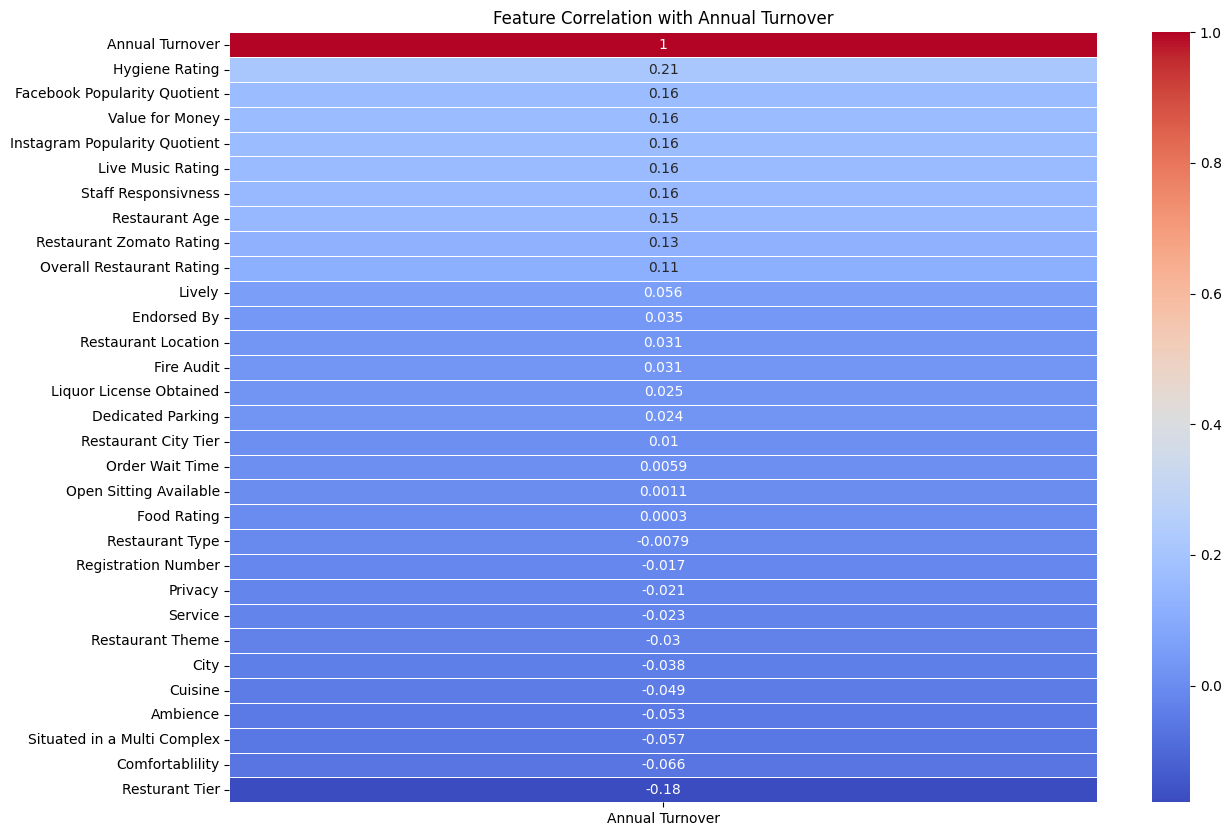

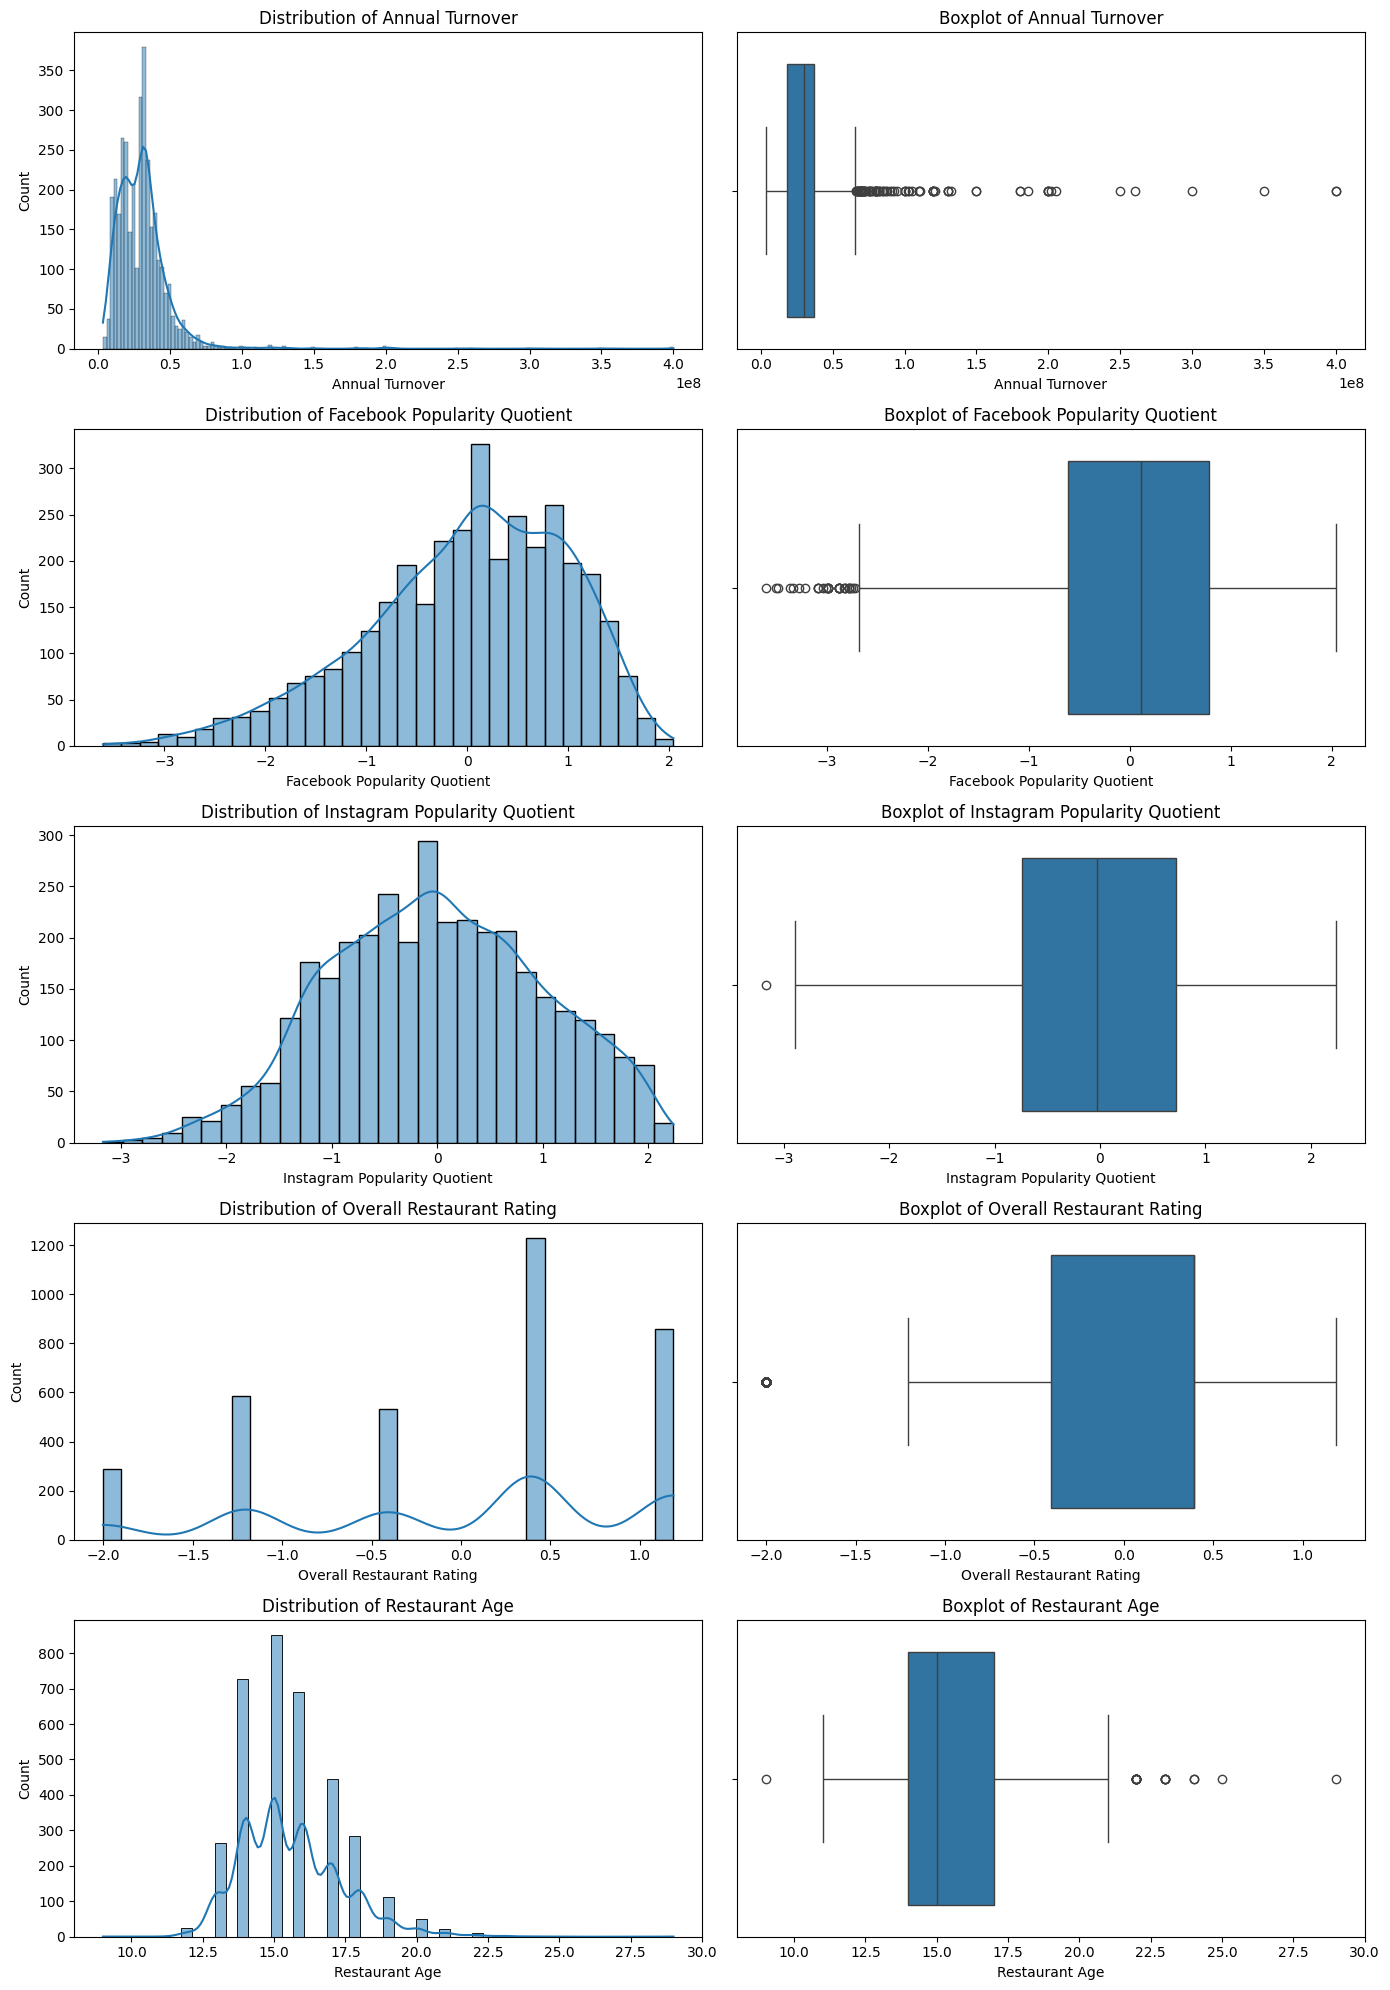

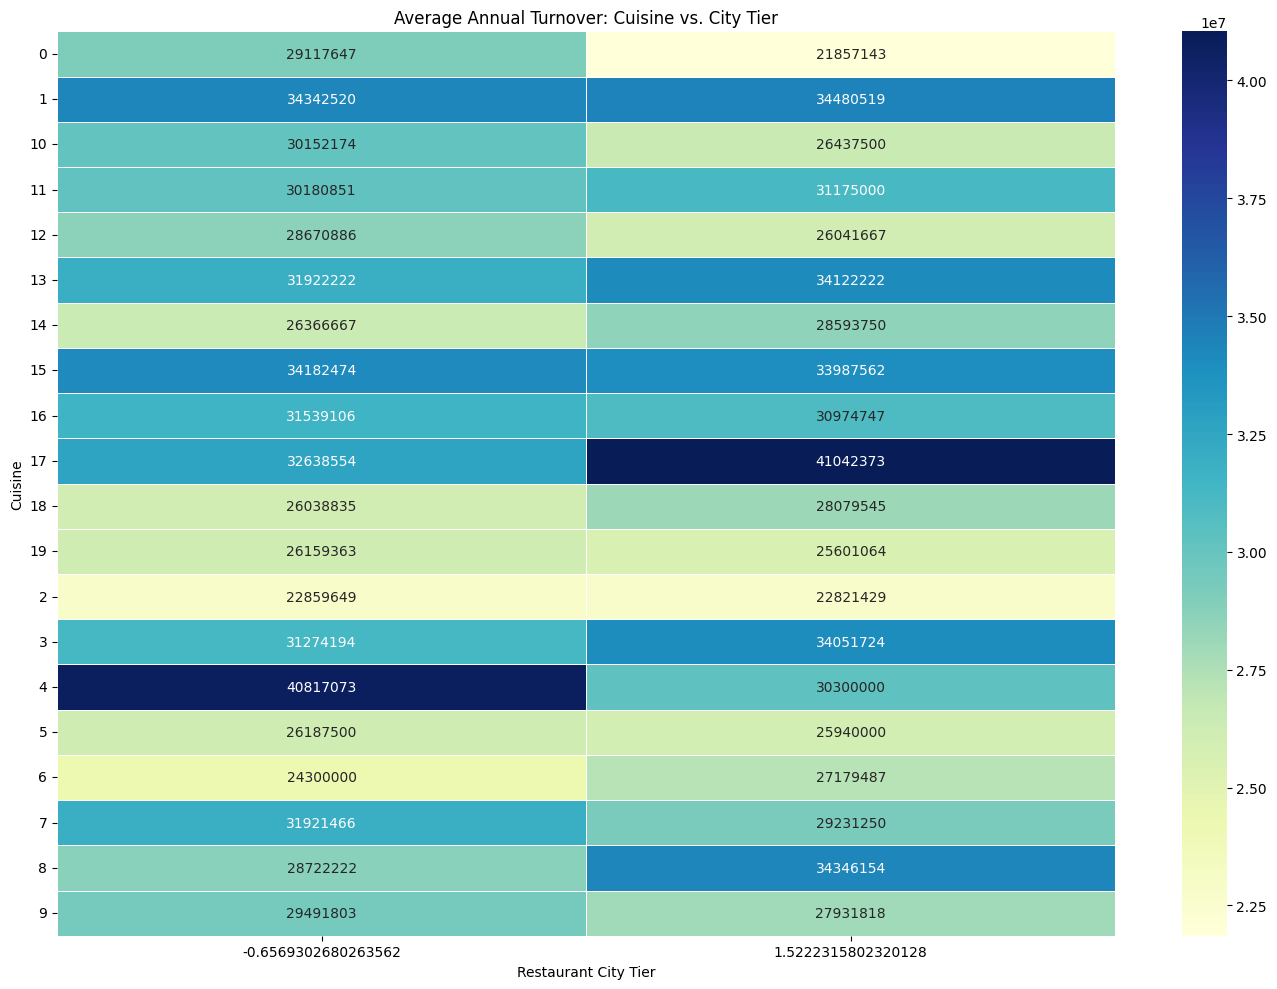

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 2: Encode Cuisine and preserve it BEFORE scaling

# Recreate LabelEncoder for Cuisine
cuisine_le = LabelEncoder()
combined_cuisines = pd.concat([train_df['Cuisine'], test_df['Cuisine']], axis=0).astype(str)
cuisine_le.fit(combined_cuisines)

# Encode Cuisine in both datasets
train_df['Cuisine'] = cuisine_le.transform(train_df['Cuisine'].astype(str))
test_df['Cuisine'] = cuisine_le.transform(test_df['Cuisine'].astype(str))

# Preserve label-encoded Cuisine before scaling
original_cuisine_encoded = train_df['Cuisine'].copy()

# Step 2.1: Correlation heatmap with Annual Turnover

plt.figure(figsize=(14, 10))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(
    corr_matrix[['Annual Turnover']].sort_values(by='Annual Turnover', ascending=False),
    annot=True, cmap='coolwarm', linewidths=0.5
)
plt.title("Feature Correlation with Annual Turnover")
plt.show()

# Step 2.2: Distribution and Boxplots

selected_cols = ['Annual Turnover', 'Facebook Popularity Quotient',
                 'Instagram Popularity Quotient', 'Overall Restaurant Rating',
                 'Restaurant Age']

fig, axes = plt.subplots(len(selected_cols), 2, figsize=(14, 4 * len(selected_cols)))
for i, col in enumerate(selected_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {col}")
    sns.boxplot(x=train_df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Step 2.3: Cuisine × City Tier Interaction Heatmap

# Scale numeric features (excluding target + categorical ones)
features_to_exclude = ['Annual Turnover', 'Cuisine', 'Restaurant City Tier']
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.difference(features_to_exclude)

scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# Decode Cuisine using preserved values
decoded_cuisine = cuisine_le.inverse_transform(original_cuisine_encoded.astype(int))
decoded_city_tier = train_df['Restaurant City Tier']

# Create pivot table and heatmap
interaction_df = pd.DataFrame({
    'Cuisine': decoded_cuisine,
    'City Tier': decoded_city_tier,
    'Annual Turnover': train_df['Annual Turnover']
})

interaction_pivot = interaction_df.pivot_table(
    index='Cuisine',
    columns='City Tier',
    values='Annual Turnover',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(interaction_pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Average Annual Turnover: Cuisine vs. City Tier")
plt.xlabel("Restaurant City Tier")
plt.ylabel("Cuisine")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import numpy as np

# Step 3.1: Prepare Features and Target
X = train_df.drop(columns=["Annual Turnover", "Registration Number"])  # drop target + ID
y = train_df["Annual Turnover"]

# Make sure test set is aligned
X_test_final = test_df[X.columns]

# Step 3.2: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3.3: Define Base Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Step 3.4: Train Models & Evaluate on Validation Set
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results[name] = rmse

# Step 3.5: Try a Stacked Ensemble Model
stacked_model = StackingRegressor(
    estimators=[
        ("ridge", models["Ridge Regression"]),
        ("gb", models["Gradient Boosting"])
    ],
    final_estimator=LinearRegression(),
    cv=5
)

stacked_model.fit(X_train, y_train)
stacked_preds = stacked_model.predict(X_val)
stacked_rmse = np.sqrt(mean_squared_error(y_val, stacked_preds))
results["Stacked Model"] = stacked_rmse

# Step 3.6: Display All RMSE Scores
print("Validation RMSE Scores:\n")
for model_name, score in results.items():
    print(f"{model_name}: {score:,.2f}")


Validation RMSE Scores:

Linear Regression: 19,637,005.54
Ridge Regression: 19,636,885.70
Random Forest: 20,211,951.46
Gradient Boosting: 19,507,739.45
Stacked Model: 19,646,443.27


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

# Step 4.1: Hyperparameter Tuning for Random Forest
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf, rf_params, cv=3, n_iter=10, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_
best_rf_rmse = np.sqrt(mean_squared_error(y_val, best_rf.predict(X_val)))

# Step 4.2: Hyperparameter Tuning for Gradient Boosting
gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5]
}

gb = GradientBoostingRegressor(random_state=42)
gb_random = RandomizedSearchCV(gb, gb_params, cv=3, n_iter=10, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
gb_random.fit(X_train, y_train)

best_gb = gb_random.best_estimator_
best_gb_rmse = np.sqrt(mean_squared_error(y_val, best_gb.predict(X_val)))

# Step 5.1: Feature Importance from Best Gradient Boosting
feature_importances = pd.Series(best_gb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Show top 10 important features
top_features = feature_importances.head(10).index.tolist()
print("\n Top 10 Features:")
print(feature_importances.head(10))

# Step 5.2: Train Model Using Only Top Features
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]

lean_model = GradientBoostingRegressor(random_state=42)
lean_model.fit(X_train_top, y_train)
lean_preds = lean_model.predict(X_val_top)
lean_rmse = np.sqrt(mean_squared_error(y_val, lean_preds))

# Step 5.3: Print Results
print("\n Hyperparameter Tuned RMSEs:")
print(f"Best Random Forest RMSE: {best_rf_rmse:,.2f}")
print(f"Best Gradient Boosting RMSE: {best_gb_rmse:,.2f}")
print(f"Lean Model (Top 10 Features) RMSE: {lean_rmse:,.2f}")



 Top 10 Features:
Restaurant Age                   0.163988
Ambience                         0.146730
Hygiene Rating                   0.142309
Live Music Rating                0.089632
Instagram Popularity Quotient    0.075789
Cuisine                          0.074333
Facebook Popularity Quotient     0.071312
City                             0.040041
Resturant Tier                   0.038364
Order Wait Time                  0.026222
dtype: float64

 Hyperparameter Tuned RMSEs:
Best Random Forest RMSE: 19,569,334.59
Best Gradient Boosting RMSE: 19,418,485.87
Lean Model (Top 10 Features) RMSE: 20,014,550.59


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 6: Define and Train the Stacking Mode
stacked_final = StackingRegressor(
    estimators=[
        ('rf', best_rf),            # Tuned Random Forest
        ('gb', best_gb)             # Tuned Gradient Boosting
    ],
    final_estimator=Ridge(alpha=1.0),  # Final estimator
    cv=5,
    n_jobs=-1
)

# Fit on full training data
stacked_final.fit(X, y)

# Optional: check RMSE on validation set for comparison
stack_val_preds = stacked_final.predict(X_val)
stack_val_rmse = np.sqrt(mean_squared_error(y_val, stack_val_preds))
print("Stacked Model RMSE on Validation Set: {stack_val_rmse:,.2f}")

# Step 7: Predict on the Test Set
test_predictions = stacked_final.predict(X_test_final)

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    'Registration Number': test_df['Registration Number'],
    'Predicted Annual Turnover': test_predictions
})

# Save to CSV
submission_df.to_csv("restaurant_turnover_predictions.csv", index=False)

# Show preview
submission_df.head()


Stacked Model RMSE on Validation Set: {stack_val_rmse:,.2f}


,Registration Number,Predicted Annual Turnover
0,-41.400628,2.784111e+07
1,-41.399636,3.437252e+07
2,-41.398644,3.055337e+07
3,-41.397652,4.471886e+07
4,-41.396661,4.945634e+07


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=submission_df)

https://docs.google.com/spreadsheets/d/1SdVnABlCvXSfR4AT7tdlXL9Q7C4kwDKVAyVuT80Iufk/edit#gid=0


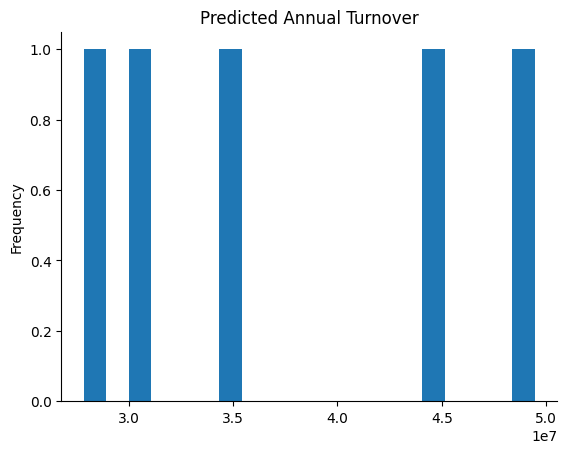

In [ ]:
from matplotlib import pyplot as plt
_df_1['Predicted Annual Turnover'].plot(kind='hist', bins=20, title='Predicted Annual Turnover')
plt.gca().spines[['top', 'right',]].set_visible(False)